In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd
sn.set_context('notebook')

# Markov chain Monte Carlo (MCMC) methods

In the previous notebook we saw how Monte Carlo (MC) methods can be used to draw representative samples from difficult distributions and also to integrate functions that have no analytical solution. However, we also saw that many basic MC techniques become inefficient for high-dimensional problems.

There are many ways in which simple MC algorithms can be improved, but in this notebook we're going to focus on just one very powerful sub-set of MC methods: **Markov chain Monte Carlo (MCMC)**.

One characteristic of the MC methods discussed previously is that they rely on **independent random sampling**. This independence is a useful property, but it also leads to inefficiencies. Ultimately, we want to draw a representative sample from some complex distribution, $f(x)$, which might be e.g. our posterior distribution from a model calibration exercise. To do this, we need to draw more samples from regions of $f(x)$ with high probability density and fewer samples from regions with low probability density. Because standard MC approaches use independent sampling, the algorithms do not "know" when they're in high density portions of the parameter space. To improve matters, we might construct an algorithm with a "memory" of its previous samples, which it could use to identify relatively high density areas compared to where it's been previously. Having identified such a region, the algorithm might decide to draw more samples from that part of the parameter space, thereby producing a representative sample from $f(x)$ more quickly.  

This idea introduces a few new problems. In particular, if we choose the next sample, $x_{i+1}$, based on the current sample, $x_i$, then the samples will be auto-correlated, which means that each individual sample contains less new information about $f(x)$ than if the samples were independent. On the other hand, this approach may be more efficient than an independent sampling strategy, because the algorithm will focus on the most important regions of the parameter space. We may therefore be able to get away with fewer samples, even if the information content of each one is reduced.

## 1. Markov chains

A [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) is a random process where the next state of the chain depends *only* on the current state and not on the sequence of events that preceded it. The most commonly used analogy for a Markov chain is that it's like a drunken man staggering along a street: his location after his next step is determined by his current location, plus a random perturbation. He therefore takes a **random walk** through the landscape.

At the risk of stretching this analogy too far, the Markov chains that we will use are more like drunken *mountaineers*, because they also possess a desire or tendency to move *uphill*, towards regions of higher probability density. However, it is important to note  that they do not *always* move uphill (sometimes they will descend or contour a bit), but in general they like to spend more time on the high ground than down in the valleys. 

Note that if our "mountaineers" *did* always move uphill in our probability landscape we would actually be constructing an *optimiser* (and an inefficient one at that) rather than a sampler. If we just want to find the highest point in our landscape there are plenty of better options out there - see the section on Maximum Likelihood Estimation at the end of notebook 2, for example. However, we don't want an optimiser; we want to draw a representative sample from our target distribution, and this means our "mountaineers" must occasionally go down to sample from the low probability "valleys", as well as spending most of their time on the high probability "mountain tops".

## 2. Brief reminder on rejection sampling

In the last notebook we discussed **non-uniform rejection sampling**, where we introduced a function, $mQ(x)$, which we know to be greater than $f(x)$ everywhere in our region of interest. We then drew independent samples, $x_i$, from $Q(x)$ and accepted them as samples from $f(x)$ if

$$y_i \leq f(x_i) \qquad where \qquad y_i \sim U(0, mQ(x_i))$$

In other words, where the $y_i$ are drawn from a uniform distribution between 0 and $mQ(x_i)$. 

Before we move on, we will first write this acceptance rule in a slightly different way. Drawing a value from a uniform distribution between 0 and some constant is the same as drawing from a uniform distribution between 0 and 1 and then multiplying by the constant

$$U(0, mQ(x_i)) = mQ(x_i) \times U(0,1)$$

Therefore we accept when 

$$y_i \leq \frac{f(x_i)}{mQ(x_i)} \qquad where \qquad y_i \sim U(0,1)$$

This gives exactly the same result as before, but this time we calculate the ratio, $\alpha = \frac{f(x_i)}{mQ(x_i)}$, and we also draw a random number, $y_i$, uniformly from the range between 0 and 1. If $y_i \leq \alpha$ then the point $x_i$ is accepted as a sample from $f(x)$.

## 3. The Metropolis algorithm

The most basic MCMC algorithm is the **[Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)**, which is both remarkably simple and extremely powerful. The algorithm proceeds as follows:

1. Begin at an arbitrary point, $x_0$, within the parameter space. <br><br>

2. Choose an arbitrary distribution, $Q(x)$, for determining the random component of the step. This is called the **jump** or **proposal** distribution and for the Metropolis algorithm it must be **symmetric**. In most cases it is chosen to be **Gaussian**. The jump distribution is centred on the current location, $x_i$, and provides a probability distribution for selecting a candidate location for the next step, $x_{i+1}$. If the distribution is Gaussian then points closer to $x_i$ are more likely to be chosen as candidates than those further away.<br><br>

3. Use the proposal distribution to generate a candidate location for the next point in the chain, $x_{i+1}$. <br><br>

4. Evaluate $\alpha = \frac{f(x_{i+1})}{f(x_i)}$.

    * If $\alpha \geq 1$ then $x_{i+1}$ has a higher probability density than $x_i$, so because our "drunken mountaineers" like to move uphill, we accept $x_{i+1}$ as the next step in the Markov chain and move to that location.<br><br>
    
    * If $\alpha < 1$, draw a value, $y_i$ from a uniform distribution between 0 and 1. Accept $x_{i+1}$ as the next step in the chain if $y_i \leq \alpha$, otherwise reject $x_{i+1}$ and remain at $x_i$ for this step. Note that this rejection rule is essentially the same as for **rejection sampling** (see above), except here we're applying it to subsequent steps in a Markov chain. This rule means that, when $\alpha < 1$, the probability of the chain moving "downhill" to an area with lower probability density is $\alpha$. <br><br>
    
5. Return to step 3 and repeat.

It can be proved that, as the number of steps in the chain becomes large, the distribution of samples in the chain converges on the distribution of $f(x)$. Although I'm not going to reproduce the proof here, I hope you can see intuitively why it works:

* The Markov chain takes a random walk through the probability landscape defined by $f(x)$. The chain has a tendency to move uphill, because when the newly proposed point has higher probability density than the current point the proposal is *always* accepted. This means that if the chain finds itself in a region with low probability density, it will rapidly move towards a more probable area.  <br><br>

* The proposed point is also *sometimes* accepted even when its probability density is lower, so the algorithm can still move "downhill". If the probability density at $x_{i+1}$ is only half that at $x_i$ then, in order to draw a representative sample, we want roughly twice as many samples from $x_i$ as from $x_{i+1}$. According to the acceptance rule for the Metropolis algorithm, the probability of accepting $x_{i+1}$ as the next point in the chain is $\frac{f(x_{i+1})}{f(x_i)} = 0.5$. Over a large number of steps, we therefore expect the chain to return roughly half as many samples from $x_{i+1}$ as from $x_i$, exactly as desired. In this way, the chain has a tendency to move towards high-density regions of $f(x)$, while only visiting lower density regions in proportion to their relative density.

Let's use the Metropolis algorithm to draw a sample from the same function used as an example in notebook 3

$$f(x) = (\sin^2 x + 0.3)e^{-0.5x^2}$$

Note that, as with the previous examples, we're only interested in determining the *shape* of the function $f(x)$ (i.e. evaluating it to within a multiplicative constant). Note also that we need to choose a **starting point**, $x_0$, for our Markov chain as well as a **proposal distribution**, $Q(x)$. In the example below we arbitrarily choose $x_0 = 0$ and $Q(x)$ to be a Gaussian distribution with standard deviation 1. We'll return to these assumptions later.

Acceptance rate: 70.8%


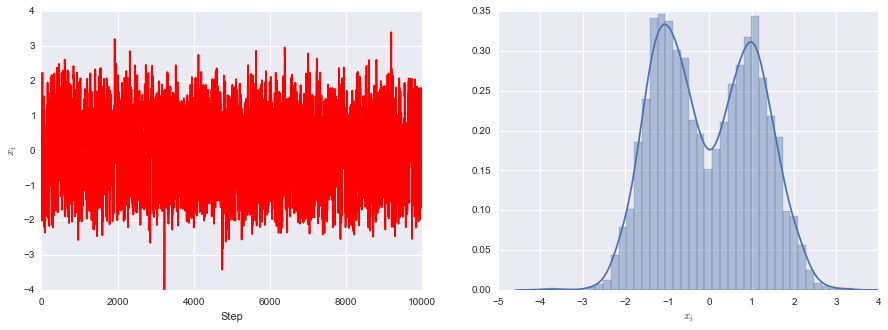

In [2]:
def f(x):
    """ This is the function we want to integrate.
    """
    return (np.sin(x)**2 + 0.3)*np.exp(-0.5*x**2)

def metropolis(x_0, sigma, n):
    """ Simple implementation of the Metropolis algorithm. Returns
        chain and acceptance rate
            
            x_0 is the starting point for the chain
            sigma is the std. dev. of the proposal distribution
            n is the number of steps to take
    """
    # Counter for number of accepted jumps
    n_accept = 0.

    # Create a chain and add x_0 to it
    chain = [x_0,]

    # Draw n random samples from Gaussian proposal distribution to use for 
    # determining step size
    jumps = np.random.normal(loc=0, scale=sigma, size=n)

    # Draw n random samples from U(0, 1) for determining acceptance
    y_i = np.random.uniform(low=0, high=1, size=n)

    # Random walk
    for step in xrange(1, n):
        # Get current position of chain
        x = chain[-1]

        # Get a candidate for x_i+1 based on x_i and jump
        cand = x + jumps[step]

        # Calculate alpha
        alpha = f(cand)/f(x)

        # Accept candidate if y_i <= alpha
        if y_i[step] <= alpha:
            x = cand
            n_accept += 1
        chain.append(x)

    # Acceptance rate
    acc_rate = (100*n_accept/n)
    
    return [chain, acc_rate]

def plot_metropolis(chain, acc_rate):
    """ Plot results of Metropolis algorithm.
    """
    print 'Acceptance rate: %.1f%%' % acc_rate

    # Plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Plot chain
    axes[0].plot(range(len(chain)), chain, 'r-')
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('$x_i$')

    # Plot normalised histogram of accepted values
    sn.distplot(chain, ax=axes[1])
    axes[1].set_xlabel('$x_i$')
    plt.show()

x_0 = 0    # Starting location
sigma = 1  # Std. dev. for proposal distribution
n = 10000  # Number of steps to take

chain, acc_rate = metropolis(x_0, sigma, n)
plot_metropolis(chain, acc_rate)

The plot on the left above illustrates the random walk taken by our Markov chain through the (one-dimensional) parameter space of $f(x)$. You can see that the chain very occasionally explores values towards the extremes of the distribution (such as $\pm 3$), but spends the vast majority of its time in the region between about $\pm 1$, which is where most of the probability desnity of $f(x)$ is located. 

Of course, in the example above we chose $x_0 = 0$, which is already a pretty good starting position for our chain - it's located right in the middle of our target distribution. What if we start from somewhere that is far away from the high density region of $f(x)$? In the example below, I've chosen $x_0 = -10$ and I've also reduced the number of samples to just 1000 to make it easier to see the evolution of the chain.

Acceptance rate: 69.8%


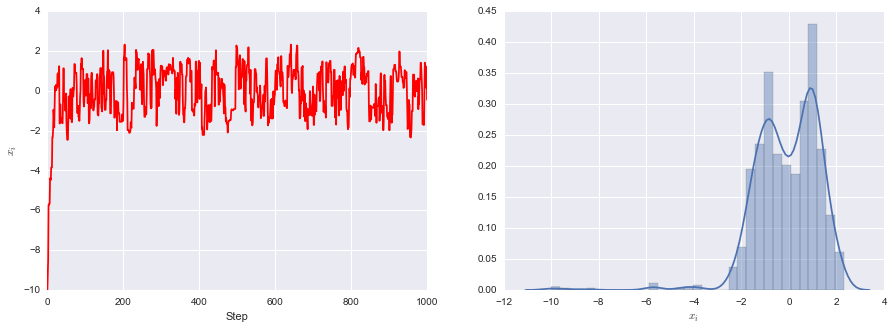

In [3]:
x_0 = -10 # Starting location
sigma = 1 # Std. dev. for proposal distribution
n = 1000  # Number of steps to take

chain, acc_rate = metropolis(x_0, sigma, n)
plot_metropolis(chain, acc_rate)

As you can see, regardless of the starting point, the chain moves rapidly back towards the region of high probability density and then remains in that general area, sampling from the distribution. In high-dimensional parameter spaces, this behaviour is one of the great advantages of MCMC methods over traditional MC alternatives: the Markov property enables the chain to explore the parameter space in a more intelligent way, by focusing its attention on each region in proportion to its probability density.

Note, however, that by choosing a poor starting location, the early part of the chain (roughly the first 50 or so steps in the example above) is not representative of rest of the sample. From about step 50 onwards, the general position of the chain is stable and we say that it has **converged** on the target distribution. Until this happens, we cannot be sure that the chain is returning samples from the target, so it is usual to discard the early portion of the chain, which is called the **burn-in** period. The burn-in period is the time it takes the chain to "forget" about it's starting point (which is arbitrary) and start returning representative samples from the target distribution.

Defining convergence rigorously turns out to be quite difficult, but fortunately it's usually obvious from trace plots, as in the example above. An additional step that is often taken after discarding the burn-in is to select only every $k th$ element from the converged chain. This is called **thinning** and is done to reduce auto-correlation in the series of samples used to represent $f(x)$.

Acceptance rate: 71.5%


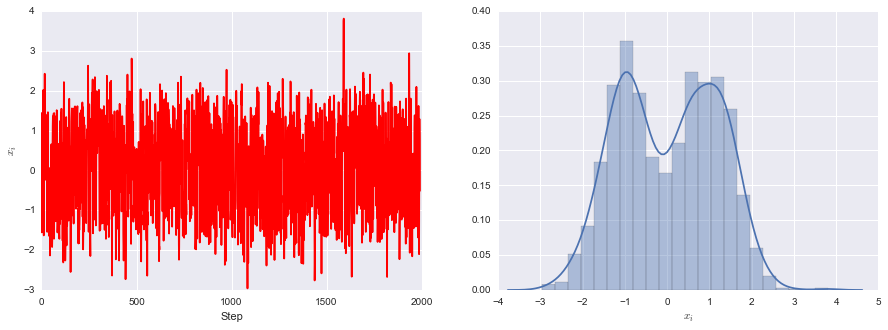

In [4]:
x_0 = -10    # Starting location
sigma = 1    # Std. dev. for proposal distribution
n = 10000    # Number of steps to take

burn_in = 50 # Number of steps to discard at start
thin = 5     # Keep only every "thin" steps

chain, acc_rate = metropolis(x_0, sigma, n)

# Discard burn-in and thin, then plot
plot_metropolis(chain[burn_in::thin], acc_rate)

## 4. Convergence efficiency

As noted above, in addition to choosing the starting location for our Markov chain, to run the Metropolis algorithm we must also choose a proposal distribution. In the example above we chose a Gaussian distribution with standard deviation 1, but would other distributions have worked just as well?

The good news is that the Metropolis algorithm is **guaranteed** to converge on the true distribution of $f(x)$, regardless of the proposal distribution chosen. This is a remarkable result: no matter how complex the target distribution, we can choose *any* symmetrical proposal distribution and be confident that the algorithm will eventually yield a representative sample of our target function. The downside is that the algorithm is **not** guaranteed to converge within a **practically useful time frame**.

In the example above, if we choose a small value for the standard deviation, $\sigma$, then the jump distribution is very narrow and pointed and the chain will take small steps through the probability landscape (because the probability of stepping far away from the current position will be small). As a result, it may take a long time to thoroughly explore the space. On the other hand, if we make $\sigma$ large the chain will take long strides across the landscape. If the bulk of the target function, $f(x)$, happens to be confined to a fairly small part of the parameter space (which is often the case), this may result in the chain repeatedly jumping away from the high density region of interest, thus reducing the sampling efficiency. In an ideal world we want to achieve a compromise between these two extremes. This is sometimes referred to as the **[Goldilocks principle](https://www.google.co.uk/search?q=goldilocks%20MCMC&gws_rd=ssl#q=goldilocks+principle+MCMC)**: we want to find a step size that is not too large, not too small, but *just right*.

The code below is the same as that above, but this time using $\sigma = 10$ instead of $\sigma = 1$. We can immediately see that, at least for this very simple example, both choices appear to converge and produce a pretty good approximation of our target function, which is reassuring. Note, however, the very different acceptance rates: about 70% in the first example versus around 14% in the second.

Acceptance rate: 13.9%


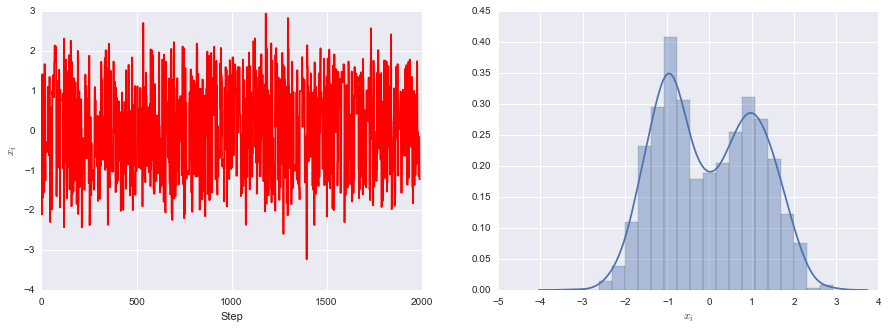

In [5]:
x_0 = -10    # Starting location
sigma = 10   # Std. dev. for proposal distribution
n = 10000    # Number of steps to take

burn_in = 50 # Number of steps to discard at start
thin = 5     # Keep only every "thin" steps

chain, acc_rate = metropolis(x_0, sigma, n)

# Discard burn-in and thin, then plot
plot_metropolis(chain[burn_in::thin], acc_rate)

So which is better? The true optimal acceptance rate will vary from problem to problem, according to the shape of the target function. In fact, as we saw in the previous notebook for importance and rejection sampling, **the algorithm will converge most rapidly if the proposal distribution is similar in shape to the target distribution**. 

Without going into any details, it has been shown (e.g. [here](http://www.maths.lancs.ac.uk/~sherlocc/Publications/rwm.final.pdf)) that acceptance rates of around 20% are close to optimal for a broad range of problem classes. 23.4% is often quoted as the ideal value, but this is only true under particular assumptions. In practice, unless you have reason to believe otherwise, it is usually a good idea to aim for acceptance rates of between about 20% and 50%.

## 5. Adaptive algorithms

One way to achieve an acceptance rate of about 23% is to run the code above, manually experimenting with different values for $\sigma$ (you should find that a value of 6 is about right). This is laborious, however, and an attractive alternative is to let the proposal distribution (i.e. $\sigma$) **adapt** as the chain progresses. The basic idea is very simple: at various points during the random walk (e.g. every $n$ steps) we calculate the acceptance rate for the previous $n$ steps. If the value is too low we make $\sigma$ smaller, whereas if it's too high we make $\sigma$ bigger.

Unfortunately, this approach violates the Markovian property of our chain, because the position at the next step is now dependent on the previous $n$ steps, instead of only on the current position. The convergence of the Metropolis algorithm is only guaranteed for true Markov chains, so unless we take care over the way we introduce the "adaptation", we can no longer be sure that our algorithm will converge on the target function. One solution is to attempt to develop an adaptive algorithm for which convergence *can* be proved. This is usually difficult, but it has been done and there are R and Python packages available which implement such algorithms. A less efficient but very pragmatic alternative is to use a non-Markovian adaptation strategy during the burn-in phase to tune the proposal distribution. The adaptative component is then turned off and the "optimised" proposal distribution is used with the standard Metropolis algorithm to generate samples from the target distribution. This simple approach offers some of the advantages of a true adaptive MCMC algorithm without the need to worry about difficult convergence proofs. 

## 6. Multiple chains

Another obvious extension of the basic Metropolis algorithm is to consider **multiple chains**. If we start several chains from different parts of the probability landscape and allow each of them to converge, they will each generate their own sample from the posterior distribution. These can be combined to give a single large sample. This approach has a number of advantages over an algorithm with just a single chain. Firstly, from a practical viewpoint the method is very amenable to parallel processing, as each chain can be assinged to a separate process or core, making it possible to generate large samples quickly. There are also theoretical advantages: for example, starting several chains from different locations reduces the influence of any one particular starting point, which may allow shorter burn-in periods to be used. More importantly, with a single chain there is a chance of getting "stuck" on a **local maximum** in the posterior surface. If the posterior distribution is strongly multimodal, with several "peaks" separated by deep "valleys", a single chain may start by moving towards the nearest peak, but then fail to explore other (potentially higher) peaks in the vicinity because the **acceptance probability** assciated with descending and crossing the intermediate valley is low. Multiple chains have a better chance of exploring the full posterior surface because, in simple terms, each chain can explore a different "peak".

Sophisticated multi-chain algorithms may also include **communication** or **mixing** between the chains. Returning to the slightly dodgy analogy introduced above of a Markov chain as a *drunken mountaineer*, multiple chains can be envisaged as having lots of mountaineers in different places, while "mixing" is the equivalent of giving each of them a walkie-talkie, so that he or she can notify the others of anything interesting (like a high peak). If one of the chains reaches a region with higher probability density than any of the others, the other chains can learn from this and move towards the high density area.

## 7. Putting it all together

In this section we will bring together everything from the previous notebooks to show how the Metropolis algorithm can be used to perform **simple linear regression**. If this seems like a very complicated way to do a simple task, you're right - it is. However, most people are familiar with simple linear regression so it's a nice way to bring lots of concepts together. The great thing about this approach is that it's very general: as we'll see in the next notebook, it's possible to switch from considering simple linear regression to calibrating a complex environmental model with very few changes.

Over the next couple of notebooks we'll also introduce some Python packages that make coding all this much easier, as well as providing more sophisticated adaptive and multi-chain algorithms. In most real applications **you will probably want to make use of these packages**, but as they're all essentially developments of the Metropolis algorithm it's useful to understand the basics in detail first.

### 7.1. Generate some data

We'll start by generating some "fake" data that we can use to test the approach. This means that, unlike in the real world, we know the true parameters that we're looking for. 

We'll assume that the true data generating process is a simple linear model with independent Gaussian random noise

$$y = \alpha x + \beta + \epsilon \qquad where \qquad \epsilon \sim \mathcal{N}(0, \sigma_\epsilon)$$

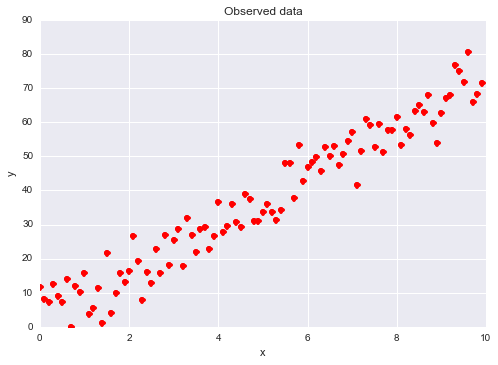

In [6]:
# Generate some fake data
alpha_true = 7
beta_true = 3
sigma_e_true = 5

x = np.arange(0, 10, 0.1)
obs_y = alpha_true*x + beta_true + np.random.normal(loc=0, scale=sigma_e_true, size=len(x)) # The observed data

plt.plot(x, obs_y, 'ro')
plt.title('Observed data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 7.2. Deterministic model

Now we return to our **deterministic black box model** from notebook 2. 

<img src="https://drive.google.com/uc?export=&id=0BximeC_RweaeS0VjbDgyeVdTMXM" alt="Black box model" height="400" width=400> 

As before, this model could be anything (e.g. a complex hydrological model), but for this example we're going to assume that it simply implements the calculation $y = \alpha x + \beta$. In other words, the user chooses values for $\alpha$ and $\beta$ by turning the dials and then supplies as input a vector of data, $x = \{x_1, .., x_n\}$. After pressing the "run" button, the model returns a vector of output values, $y = \{y_1, .., y_n\}$, calculated as $y_i = \alpha x_i + \beta$.

We want to find estimates for the parameters $\alpha$ and $\beta$ that give the best fit to the test data. Just as importantly, we also want to understand the **uncertainty** in these estimates i.e. how much **confidence** should we have that the fitted values are the right ones?

We'll start by defining a simple function to represent our deterministic model.

In [7]:
def deterministic_model(x, params):
    """ x is a 1D vector of x values
        params is the vector of parameters [alpha, beta]
        
        Returns alpha*x + beta
    """
    # Extract parameters
    alpha, beta = params
    
    # Linear model
    return alpha*x + beta

### 7.3. Define likelihood

Next we need to define our likelihood function. To do this we must think about the error structure we expect between our model and the observations. In this example we will assume independent and identically distributed Gaussian errors with mean 0 and standard deviation, $\sigma_\epsilon$. We know that this is the correct error structure in this case because we generated the test data above using exactly these assumptions. In the real-world, however, deciding on the error structure and devising the likelihood function are often the most difficult parts of the calibration exercise.

As described in notebook 2, in order to avoid numerical errors in our code it is best to consider the **log likelihood** and the **log prior**. Also recall that we only need to think about quantities that are **proportional to** the distributions of interest i.e. we only need to evaluate them to within a multiplicative constant. 

The log likelihood function in this case is exactly the same as the one described in detail in section 2.3 of notebook 2 - please refer to that if you need a reminder.

In [8]:
def log_likelihood(x, params, obs):
    """ x is a 1D vector of x values
        params is a vector of parameter estimates [alpha, beta, sigma_e]
        obs is the observed dataset used for calibration
        
        Returns the log likelihood assuming iid Gaussian errors
    """
    # Get number of value pairs
    n = len(obs)
    
    # Extract parameter values
    alpha, beta, sigma_e = params
    
    # Calculate deterministic model results with these parameters
    sim = deterministic_model(x, [alpha, beta])
    
    # Calculate log likelihood (see Section 2 of notebook 2 for explanation)
    ll = -n*np.log(2*np.pi*sigma_e**2)/2 - np.sum(((obs - sim)**2)/(2*sigma_e**2))
    
    return ll

### 7.4. Define priors

To take a Bayesian approach, we next need to define our **prior beliefs** about the parameters $\alpha$ and $\beta$, as well as about the standard deviation of the errors, $\sigma_\epsilon$. We'll assume, as in the illustration of the model above, that we have reason to believe that $\alpha$ and $\beta$ are both continuous variables lying between 0 and 12. Because we have no reason to believe that any particular values within this range are more likely than others, we will define our **priors** as **uniform distributions** over this interval

$$\alpha \sim \mathcal{U}(0, 12) \qquad \beta \sim \mathcal{U}(0, 12)$$

We won't make any assumptions about $\sigma_\epsilon$, other than it **must be positive** (negative values for the standard deviation don't make any sense). All positive values for $\sigma_\epsilon$ will be considered equally likely.

Because we are only interested in values that are proportional to the probability density of interest, for $\alpha$ and $\beta$ we can simply associate any values between 0 and 12 with a constant (e.g. zero). Values outside this range have zero probability, which on a log scale becomes $\log(0) = -\infty$

In [9]:
def log_prior(params):
    """ params is the vector of parameters [alpha, beta]
    
        Return the log prior probability of p
    """
    alpha, beta, sigma_e = params
    
    # If all parameters are within allowed ranges, return a constant 
    # (anything will do - I've used 0 here)
    if ((0 <= alpha < 12) and (0 <= beta < 12) and (0 <= sigma_e)):
        return 0
    # Else the parameter set is invalid (probability = 0; log prob = -inf)
    else:
        return -np.inf

### 7.5. Define posterior

The **posterior distribution** (to within a multiplicative constant) is just the prior multipled by the likelihood, as described in notebook 3. The **log posterior** is therefore the **sum** of the log prior and the log likelihood. 

Note that we can save ourselves a bit of computational time by *only* evaluating the likelihood when the prior probability of the parameter set is not zero (i.e. the log prior is finite). If the prior probability is zero then that parameter set is deemed to be impossible, regardless of how well the model results fit the data: the log prior will be $-\infty$, so no matter how big the likelihood is the log posterior will still be $-\infty$. In this example, evaluating the likelihood (i.e. running the model) is very fast, so we don't need to worry about performance too much. However, when our models become more complex and computationally expensive it is useful to run them only when absolutely necessary.

As an aside, note also that for the reasons stated above you should be careful when assigning zero prior probability to particular parameter combinations. These parameter sets will be considered invalid by the algorithm, so you need to be certain that they *really are impossible*, rather than just very unlikely. If in doubt, it's better to assign very small but non-zero probabilities to these combinations, for example by using broad Gaussians for your priors rather than uniform distributions.

In [10]:
def log_posterior(x, params, obs):
    """ x is a 1D vector of x values
        params is a vector of parameter estimates [alpha, beta, sigma_e]
        obs is the observed dataset used for calibration
        
        Returns the log posterior
    """
    # Extract parameter values
    alpha, beta, sigma_e = params
    
    # Get log prior prob
    log_pri = log_prior(params)

    # Evaluate log likelihood if necessary
    if np.isfinite(log_pri):
        log_like = log_likelihood(x, params, obs)
        
        # Calculate log posterior
        return log_pri + log_like
    
    else:
        # Log prior is -inf, so log posterior is -inf too
        return -np.inf

### 7.6. Metropolis algorithm

Next, we need a version of the metropolis algorithm capable of working with this multi-dimensional problem. The model that we're fitting has three parameters: $\alpha$, $\beta$ and $\sigma_\epsilon$ (the latter is necessary because it determines the spread of the errors, so although we're only really interested in $\alpha$ and $\beta$, we need to estimate $\sigma_\epsilon$ as well).

Our Metropolis algorithm must therefore make jumps within this three dimensional parameter space, rather than the 1D space in the examples above. To do this, we'll define a three-dimensional **Gaussian jump distribution**, which involves specifying three additional constants for the jump distribution variances. We will call these variances ${\sigma_\alpha}^2$, ${\sigma_\beta}^2$ and ${\sigma_\sigma}^2$, but it is important not to get confused between these values and the parameters we're trying to estimate ($\alpha$, $\beta$ and $\sigma_\epsilon$).  

$\sigma_\alpha$, $\sigma_\beta$ and $\sigma_\sigma$ are **properties of the Metropolis algorithm**. In theory, the algorithm will converge regardless of the values choosen but, as described above, for efficiency reasons we should aim to **tune** them to achieve acceptance rates of around 20 to 50%.

We will further assume that $\sigma_\alpha$, $\sigma_\beta$ and $\sigma_\sigma$ are independent of one another i.e. the covariance matrix looks something like this (see section 1.3 of notebook 1 for a reminder about covariance matrices)

|   |$\alpha$|$\beta$|$\sigma_\epsilon$|
|:-:|:-:|:-:|:-:|
|$\alpha$|${\sigma_\alpha}^2$|0|0|
|$\beta$|0|${\sigma_\beta}^2$|0|
|$\sigma_\epsilon$|0|0|${\sigma_\sigma}^2$|

Finally, it's worth noting that because we're working with log probabilities we need to re-write the code for calculating **acceptance**. As described above in section 3, to determine the acceptance probability we calculate the ratio of the posterior probability of the proposed point to the posterior probability of the current location

$$P_{accept} = \frac{P(x_{i+1})}{P(x_i)}$$

However, we are currently working with $\log[P(x_{i+1})]$ and $\log[P(x_i)]$. From a simple rearrangement of the logarithms, you should be able to see that 

$$P_{accept} = exp(\log[P(x_{i+1})] - \log[P(x_i)])$$

as used in the code below.

In [11]:
def metropolis_3d(start, jump_sigma, n):
    """ start is the starting location for the chain as [alpha, beta, sigma_e]
        jump_sigma gives the std. devs. for the jump distribution [sigma_alpha, sigma_beta, sigma_sigma]
        n is the number of steps to take
        
        Returns the chain and acceptance rate
    """
    # Extract jump covariances
    sigma_alpha, sigma_beta, sigma_sigma = jump_sigma
    
    # Build covariance matrix
    cov = [[sigma_alpha**2, 0, 0], 
           [0, sigma_beta**2, 0], 
           [0, 0, sigma_sigma**2]]
    
    # Counter for number of accepted jumps
    n_accept = 0.

    # Create a chain and add start position to it
    chain = np.array([start,])

    # Draw n random samples from Gaussian proposal distribution to use for 
    # determining step size
    jumps = np.random.multivariate_normal(mean=[0,0,0],
                                          cov=cov, 
                                          size=n)

    # Draw n random samples from U(0, 1) for determining acceptance
    y_i = np.random.uniform(low=0, high=1, size=n)
       
    # Random walk
    for step in xrange(1, n):
        # Get current position of chain
        cur = chain[-1]
           
        # Get a candidate for x_i+1 based on x_i and jump
        cand = cur + jumps[step]
               
        # Calculate acccept prob
        acc_prob = np.exp(log_posterior(x, cand, obs_y) - log_posterior(x, cur, obs_y))
        
        # Accept candidate if y_i <= alpha
        if y_i[step] <= acc_prob:
            cur = cand
            n_accept += 1
        chain = np.append(chain, [cur,], axis=0)

    # Acceptance rate
    acc_rate = (100*n_accept/n)

    return [chain, acc_rate]

### 7.7. Choose a starting location

We're now all set to run the calibration algorithm, but first we need to make some choices regarding where to start our Markov chain. As we saw in the example above, if we start from a region of low probability density the chain will quickly move "uphill", so for a simple problem like this one we don't need to worry too much: we can choose almost any starting location and the algorithm should still converge quickly. However, for more complex problems in high-dimensional parameter spaces, it's a good idea to find a starting location with high probability density as this will reduce the burn-in time required for the algorithm to converge. One simple way to do this is to use an optimiser to search for the **[Maximum a Posteriori (MAP)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation)** estimate for the parameters and start the chain from there.

The MAP is very similar to the **[Maximum Likelihood Estimate (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood)** that was introduced in section 2.3 of notebook 2. The MLE is simply the maximum of the likelihood function, whereas the MAP is the maximum of the *posterior distribution* (i.e. the likelihood multiplied by the prior). Although conceptually similar, the MLE and MAP are not necessarily in the same place.

In notebook 2 we wrote down a function for the negative likelihood and then used `scipy.optimize` to minimise this, which is the same as maximising the likelihood. In the sections above we've already written down a function for the log posterior, so if we now write down the negative log posterior we can use exactly the same approach to find the MAP.

In [12]:
from scipy import optimize

def neg_log_posterior(params, x, obs):
    """ Maximising the log posterior is the same as minimising the negative log
        posterior.
    """
    return -log_posterior(x, params, obs)

# Guess some starting values for [alpha, beta, sigma_e]
param_guess = [6., 6., 1.]

# Run optimiser
param_est = optimize.fmin(neg_log_posterior, param_guess, args=(x, obs_y))

# Print results
print '\n'
print 'Estimated alpha: %.2f. True value %.2f' % (param_est[0], alpha_true) 
print 'Estimated beta: %.2f. True value %.2f' % (param_est[1], beta_true) 
print 'Estimated error sigma: %.2f. True value %.2f' % (param_est[2], sigma_e_true)

Optimization terminated successfully.
         Current function value: 307.590079
         Iterations: 96
         Function evaluations: 170


Estimated alpha: 7.04. True value 7.00
Estimated beta: 2.36. True value 3.00
Estimated error sigma: 5.24. True value 5.00


You can see that the very simple code above does a pretty good job of identifying the true values for $\alpha$, $\beta$ and $\sigma_\epsilon$, **without requiring any MCMC at all**. However, the optimiser only gives a single point estimate for each parameter - it does not give any indication of **uncertainty**, which is important in real-world applications where we don't have the true values to compare to. For example, in the real world, the optimiser tells us the best estimate for $\alpha$, but we don't know whether this estimate is well-constrained by the data. Perhaps the model is largely insensitive to $\alpha$, so the value chosen doesn't matter much? Or perhaps $\alpha$ is a very important parameter indeed? 

To move beyond simple point estimates to something more useful, we need to characterise the *entire posterior distribution*, not just look for the location of the highest peak. This is where MCMC comes in, but because the point estimate from the optimiser is easy to calculate it can provide a good starting point for our Markov chain.

### 7.8. Run the MCMC

We can now run the Metropolis algorithm using the starting values estimated above. For this simple, non-adaptive algorithm, it's likely we will need to do this several times, experimenting with the values of $\sigma_\alpha$, $\sigma_\beta$ and $\sigma_\sigma$ until the accepatnce rate is between about 20% and 50%. More sophisticated algorithms can account for this automatically (see the next notebook).

Finally, before running the calibration algorithm, it worth downloading and installing **[corner plot](https://github.com/dfm/corner.py)**, which is a very useful package for visualising the output from MCMC analyses. 

Acceptance rate: 65.50%


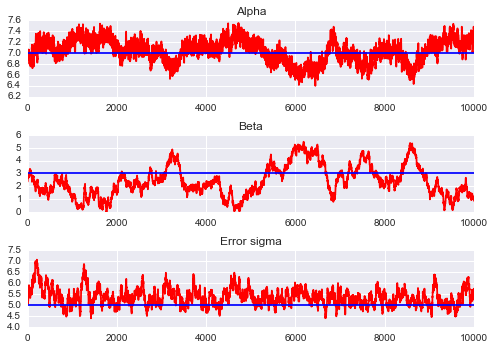

In [13]:
# Run the Metropolis algorithm using the optimised parameters as
# a starting point
chain, acc_rate = metropolis_3d(param_est, [.1, .1, .1], 10000)

# Check the acceptance rate
print 'Acceptance rate: %.2f%%' % acc_rate

# Extract the traces for each parameter
alpha_trace = chain[:,0]
beta_trace = chain[:,1]
sigma_e_trace = chain[:,2]

# Plot traces
fig, axes = plt.subplots(nrows=3, ncols=1)

n_steps = range(len(alpha_trace))

axes[0].plot(n_steps, alpha_trace, 'r-')
axes[0].axhline(y=alpha_true)
axes[0].set_title('Alpha')

axes[1].plot(n_steps, beta_trace, 'r-')
axes[1].axhline(y=beta_true)
axes[1].set_title('Beta')

axes[2].plot(n_steps, sigma_e_trace, 'r-')
axes[2].axhline(y=sigma_e_true)
axes[2].set_title('Error sigma')

plt.subplots_adjust(hspace=0.5)
plt.show()

Note from the plots above that, because we started the chain from the MAP, the chain appears to have converged more-or-less from the start. If instead we had chosen a starting point at random, we might expect to see some obvious drift as the chains converge, as in the example in section 3 above. Nonetheless, it is a good idea to discard some samples from the start of the chain as a burn-in phase, and it's also worth doing a bit of "thinning" as well.

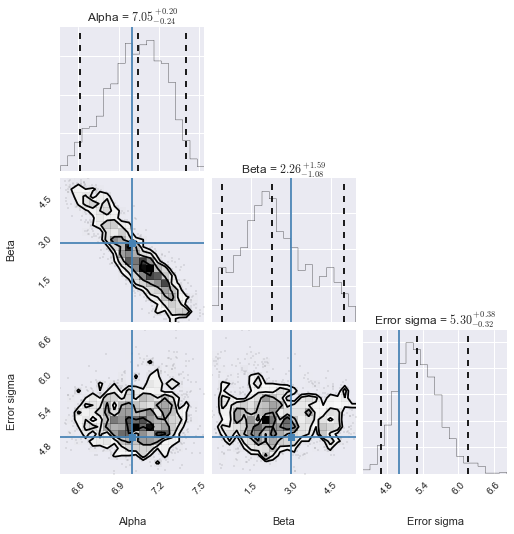

In [14]:
import corner

burn_in = 1000 # Discard the first 1000 steps
thinning = 5   # Then keep every 5th step

# Remove burn-in and thin
samples = chain[burn_in::thin]

# Triangle plot
tri = corner.corner(samples,
                    labels=['Alpha', 'Beta', 'Error sigma'],
                    truths=[alpha_true, beta_true, sigma_e_true],
                    quantiles=[0.025, 0.5, 0.975],
                    show_titles=True, 
                    title_args={'fontsize': 16})

The corner plot package provides a really nice way to visualise the results. Each of the three plots towards the lower left provides a 2D slice through the posterior distribution, while the three histograms along the diagonal show the **marginal posterior densities** for each parameter. The dotted lines mark the 2.5%, 50% and 97.5% quantiles for each distribution, which define (i) the **median** and (ii) a 95% **credible interval** for each parameter (a credible interval is the Bayesian equivalent of a Frequentist **confidence interval**). The blue lines mark the true values, which you can see are being fairly well estimated in this case.

In the middle-left panel, it's interesting to note the correlation structure between $\alpha$ and $\beta$. This indicates that the algorithm was able to find reasonably good fits to the data either by choosing large values for $\alpha$ and small ones for $\beta$, or by choosing large $\beta$ and small $\alpha$. This indicates our assumption of independence in the covariance matrix (section 7.6) was not justified, so an adpative algorithm may have converged faster for this problem (although this doesn't affect the validity of our results, and our algorithm was still fast enough, so it's probably not worth worrying about). 

### 7.9. Test the assumptions

An important final step is to test that the assumptions we have made in defining our likelihood function are valid. If they are not, our parameter estimates may be biased. Our key assumptions are that the errors are **independent and normally distributed with mean zero**. One very simple way to test this is to take the **median parameter set** from the analysis above and take a quick look at the distribution of the errors with respect to the observed data.

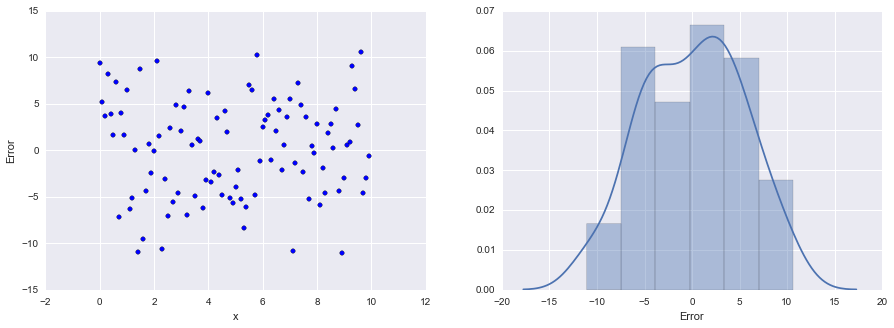

In [15]:
# Get the median param estimates
alpha_med, beta_med, sigma_e_med = np.median(samples, axis=0)

# Get y values from deterministic model with these parameters
med_y = deterministic_model(x, [alpha_med, beta_med])

# Calculate errors compared to observed data
errs = obs_y - med_y

# Plot
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
axes[0].scatter(x, errs)
axes[0].set_xlabel('x')
axes[0].set_ylabel('Error')
sn.distplot(errs, ax=axes[1])
axes[1].set_xlabel('Error')

More sophisticated diagnostic plots are possible and will be considered in a later notebook, but for now this very simple approach shows that:

  1. There is no obvious structure in the errors on the left-hand plot. For example, the errors do not become larger or smaller for larger values of $x$ (this is called [heteroscedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity)). What's more, the errors do not appear to be serially correlated. <br><br>
  
  2. The distribution of errors on the right-hand plot is approximately Gaussian with mean zero.
  
## 8. Summary

1. MCMC techniques offer **better performance** than MC approaches, because the Markov property enables the algorithms to seek out high probability regions, while still exploring low probability areas in proportion to their relative density. <br><br>

2. The simplest MCMC algorithm is the **Metropolis algorithm**, which is guaranteed to converge on the posterior (but not necessarily in a reasonable time frame). <br><br>

3. As a rule of thumb, it is usually a good idea to aim for **acceptance rates** of between about **20% and 50%**. <br><br>

4. MCMC algorithms require, as a minimum, a **starting point** and a **proposal distribution**. The starting point is often best chosen by searching for a maximum in the posterior distribution i.e. the **MAP estimate**. Sampling will be most efficient when the **proposal distribution is similar to the target distribution**. <br><br>

5. More sophisticated algorithms achieve better sampling efficiencies by using **multiple chains** and/or **adapting the proposal distribution** as the chain evolves. <br><br>

6. A variety of Python packages implement state-of-the-art MCMC samplers. The hardest part of a calibration exercise is therefore usually **formulating an appropriate likelihood function**. <br><br>

7. Having estimated parameters for a model using MCMC, it is important to **check that the assumptions of the likelihood function are valid**. This usually involves some kind of analysis of the **model residuals**. If the assumptions are not met, parameter estimates will be **biased** and you may need to repeat the exercise using a different likelihood function.